In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline


# Data source: https://www.dukascopy.com/swiss/english/marketwatch/historical/


# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [ ]:
import warnings


In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration

# absolute path method  - while in process
# C:\Users\CS_Knit_tinK_SC\Documents\GitHub\HW_7_TS_ML_Inputs-U10
filepath="C:/Users/CS_Knit_tinK_SC/Documents/GitHub/HW_7_TS_ML_Inputs-U10/Resources/yen.csv"
yen_futures = pd.read_csv(filepath, index_col="Date", infer_datetime_format=True, parse_dates=True)


# relative path method - as of submittal 
#yen_futures = pd.read_csv(
#    Path('../Resources/yen.csv'), index_col="Date", infer_datetime_format=True, parse_dates=True
#)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

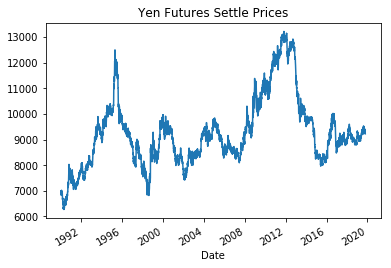

In [5]:
# Plot just the "Settle" column from the dataframe using a line plot:
# title to add: yen Futures Settle Prices
# df.Close.plot()
yen_futures['Settle'].plot(title='Yen Futures Settle Prices')

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])


In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
data_result = yen_futures[['Settle']]
ts_new = pd.concat([ts_trend, ts_noise], axis=1)
all_three=pd.concat([data_result, ts_new], axis=1)
all_three.rename(columns={'Settle_trend':'Trend','Settle_cycle':'Noise'}, inplace=True)
all_three.head()

,Settle,Trend,Noise
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
settle_trend_2015 = all_three.loc['2015':'2020']
settle_trend_2015.tail()

,Settle,Trend,Noise
Date,,,
2019-10-09,9338.0,9313.060753,24.939247
2019-10-10,9303.5,9309.368559,-5.868559
2019-10-11,9251.0,9305.454594,-54.454594
2019-10-14,9265.0,9301.423060,-36.423060
2019-10-15,9221.5,9297.344123,-75.844123


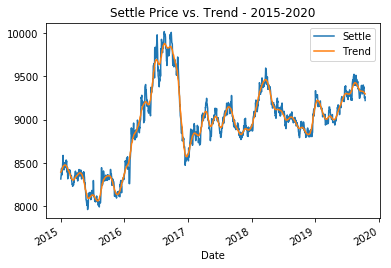

In [9]:
settle_trend_2015[["Settle", "Trend"]].plot(title="Settle Price vs. Trend - 2015-2020")

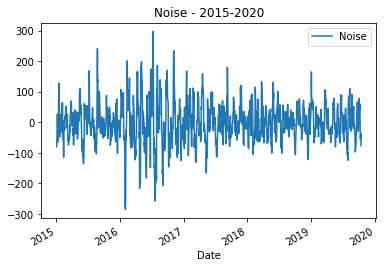

In [10]:
# Plot the Settle Noise
settle_trend_2015[["Noise"]].plot(title="Noise - 2015-2020")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [11]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns.rename(columns={'Settle':'Return_Amt'}, inplace=True)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Return_Amt
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [12]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2, 1))  # (AR = past values and errors, MA = past errors)

# Fit the model and assign it to a variable called results
results = model.fit()

C:\Users\CS_Knit_tinK_SC\anaconda3\envs\TSMLPyViz\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [13]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 15 Nov 2021   AIC                          15798.142
Time:                        15:42:45   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3067      1.277     -0.240      0.810      -2.809       2.195
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2952      1.277      0.231      0.817      -2.207       2.797
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3294           +0.0000j            3.3294            0.5000
AR.2         -156.9788           +0.0000j          156.9788            0.5000
MA.1           -3.3880           +0.0000j            3.3880            0.5000
-----------------------------------------------------------------------------
"""

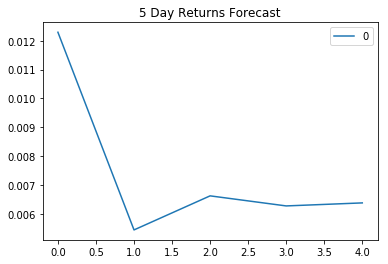

In [14]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [15]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

# Fit the model
results = model.fit()

C:\Users\CS_Knit_tinK_SC\anaconda3\envs\TSMLPyViz\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\CS_Knit_tinK_SC\anaconda3\envs\TSMLPyViz\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has

In [16]:
# Output model summary results:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Mon, 15 Nov 2021   AIC                          83905.238
Time:                        15:42:47   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8917           -1.3785j            2.3407           -0.1002
AR.2            1.8917           +1.3785j            2.3407            0.1002
AR.3           -2.2698           -3.0209j            3.7786           -0.3526
AR.4           -2.2698           +3.0209j            3.7786            0.3526
AR.5          -11.0629           -0.0000j           11.0629           -0.5000
MA.1            3.3645           +0.0000j            3.3645            0.0000
-----------------------------------------------------------------------------
"""

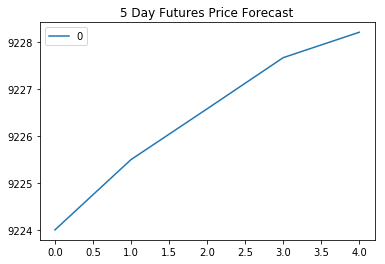

In [17]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
import arch 
from arch import arch_model

In [21]:


# Estimate a GARCH model:
# 'p' and 'q'  are akin to the 'p' and 'q' of an ARMA model.
# 'vol="GARCH"' means that we're using a GARCH model.
# The 'mean="Zero"' means that we're estimating a GARCH.
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

In [22]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:             Return_Amt   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Nov 15 2021   Df Residuals:                     7514
Time:                        15:50:46   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

C:\Users\CS_Knit_tinK_SC\anaconda3\envs\TSMLPyViz\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\CS_Knit_tinK_SC\anaconda3\envs\TSMLPyViz\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


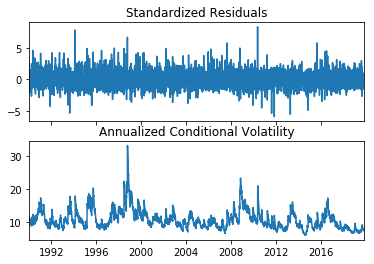

In [23]:
# Plot the model estimate of the annualized volatility
fig = res.plot(annualize='D')

In [25]:
# Find the last day of the dataset
#last_day = res.index.max().strftime('%Y-%m-%d')
#last_day

In [37]:
## Create a 5 day forecast of volatility
forecast_horizon = 5
# Take the last day of the data we used above. 
# Forecast horizon is 5, so resulting 'h.1', 'h.2', 'h.3', 'h.4', and 'h.5' 
# are the forecasts for the following 5 days.
forecasts = res.forecast(start='2015-11-09', horizon=forecast_horizon, reindex=True)

In [38]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2015-11-09,8.914801,8.938354,8.961651,8.984694,9.007487
2015-11-10,8.776544,8.801622,8.826422,8.850946,8.875200
2015-11-11,8.665394,8.691720,8.717748,8.743484,8.768931
2015-11-12,8.563047,8.590539,8.617716,8.644583,8.671145
2015-11-13,8.429025,8.458072,8.486779,8.515153,8.543197


In [31]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,...,2019-10-02,2019-10-03,2019-10-04,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-14,2019-10-15
h.1,8.932970,8.922944,8.778595,8.716086,8.575484,8.677869,8.705522,8.615929,8.678293,8.859802,...,7.601834,7.537703,7.434130,7.445496,7.363755,7.376187,7.367148,7.476222,7.389282,7.434032
h.2,8.956325,8.946409,8.803650,8.741840,8.602834,8.704054,8.731395,8.642817,8.704472,8.883958,...,7.641243,7.577978,7.475826,7.487034,7.406431,7.418689,7.409776,7.517337,7.431601,7.475729
h.3,8.979426,8.969617,8.828427,8.767305,8.629871,8.729943,8.756978,8.669398,8.730357,8.907849,...,7.680125,7.617709,7.516946,7.528001,7.448511,7.460598,7.451810,7.557889,7.473331,7.516851
h.4,9.002277,8.992574,8.852930,8.792486,8.656599,8.755542,8.782274,8.695679,8.755951,8.931478,...,7.718491,7.656905,7.557504,7.568408,7.490007,7.501928,7.493261,7.597891,7.514486,7.557410
h.5,9.024880,9.015282,8.877162,8.817387,8.683025,8.780854,8.807288,8.721663,8.781259,8.954850,...,7.756350,7.695579,7.597511,7.608267,7.530933,7.542691,7.534142,7.637353,7.555077,7.597418


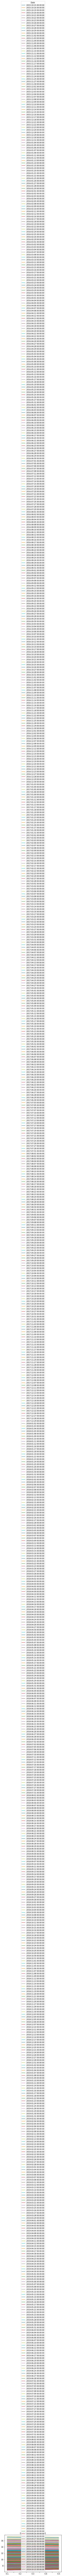

In [32]:
# Plot the final forecast
final.plot(title='GARCH volatility forecast')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?